In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
import math
%matplotlib inline

<h2 style="text-align: center;"><strong>Functions</strong></h2>

In [2]:
 
def trapezoid_mask(img_h, img_w):
    
    trapz_msk = np.zeros((img_h, img_w), dtype=np.uint8)  

    trapz_msk[ int(img_h/2):img_h, :]=1 # Setting lower half elements to 1


    # Creating triangle of zeros on lower left side of mask 
    i=0
    for row in range( int(img_h/2), img_h):
        trapz_msk[ row , 0:(int(img_w/3)-i) ]=0
        i=i+1


    # Creating triangle of zeros on lower right side of mask
    i=0
    for row in range( int(img_h/2), img_h):
        trapz_msk[ row , (int(2*(img_w/3))+i):img_w ]=0
        i=i+1
        
    return trapz_msk 

In [3]:
def hough_line(edge):
    # Theta 0 - 180 degree
    # Calculate 'cos' and 'sin' value ahead to improve running time
    theta = np.arange(0, 180, 1)
    cos = np.cos(np.deg2rad(theta))
    sin = np.sin(np.deg2rad(theta))

    # Generate a accumulator matrix to store the values
    rho_range = round(math.sqrt(edge.shape[0]**2 + edge.shape[1]**2))
    accumulator = np.zeros((2 * rho_range, len(theta)), dtype=np.uint8)

    # Threshold to get edges pixel location (x,y)
    edge_pixels = np.where(edge == 255)
    coordinates = list(zip(edge_pixels[0], edge_pixels[1]))

    # Calculate rho value for each edge location (x,y) with all the theta range
    for p in range(len(coordinates)):
        for t in range(len(theta)):
            rho = int(round(coordinates[p][1] * cos[t] + coordinates[p][0] * sin[t]))
            accumulator[rho, t] += 2 # Suppose add 1 only, Just want to get clear result

    return accumulator

<h2 style="text-align: center;"><strong>1. Conversion to HSV Color Space</strong></h2>

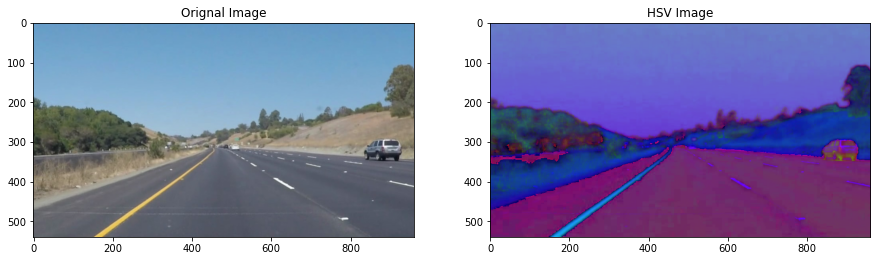

In [4]:
file='test3'
ext='.jpg'

image=plt.imread('data/'+file+ext)
address='result/'+file+'/'+file+'_'

HSV_image=cv2.cvtColor(image,cv2.COLOR_RGB2HSV)



f = plt.figure(figsize=(15,15))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.imshow(image)

ax.title.set_text('Orignal Image')
ax2.imshow(HSV_image)
ax2.title.set_text('HSV Image')

plt.ion()
plt.show()


In [5]:
B=np.ones((image.shape[0],image.shape[1]),dtype=np.uint8)

<h2 style="text-align: center;"><strong>2. Removing Noise Using Guassian</strong></h2>

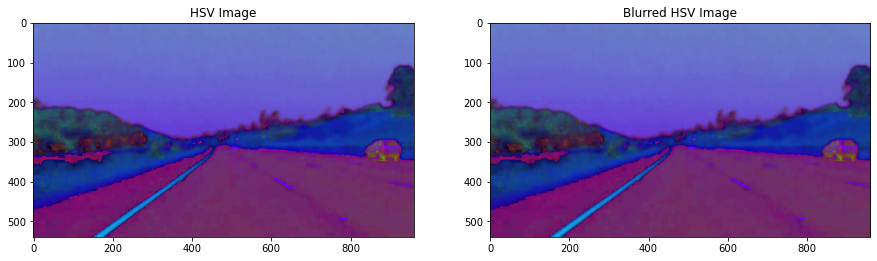

In [6]:
Blurred_HSV=cv2.GaussianBlur(HSV_image,(3,3),1)

f = plt.figure(figsize=(15,15))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.imshow(HSV_image)

ax.title.set_text('HSV Image')
ax2.imshow(Blurred_HSV)
ax2.title.set_text('Blurred HSV Image')
plt.show()


<h2 style="text-align: center;"><strong>3. Generate Binary Mask for yellow and white colored pixels</strong></h2>

In [7]:
# HSV White Ranges      
w_hl=80   ; w_hu=120

w_sl=0    ;  w_su=50

w_vl=200  ; w_vu=250

 

# HSV Yellow Ranges      
y_hl=20    ; y_hu=26

y_sl=110   ; y_su=170

y_vl=200   ; y_vu=240


bool_x = ((Blurred_HSV[:,:,0] > w_hl) & (Blurred_HSV[:,:,0] < w_hu) & (Blurred_HSV[:,:,1] > w_sl) & (Blurred_HSV[:,:,1] < w_su) &  
           (Blurred_HSV[:,:,2] > w_vl) & (Blurred_HSV[:,:,2] < w_vu) )

bool_y= ((Blurred_HSV[:,:,0] > y_hl) & (Blurred_HSV[:,:,0] < y_hu) &  
          (Blurred_HSV[:,:,1] > y_sl) & (Blurred_HSV[:,:,1] < y_su) &  
          (Blurred_HSV[:,:,2] > y_vl) & (Blurred_HSV[:,:,2] < y_vu) )



<h2 style="text-align: center;"><strong>4. Apply masks on Orignal Image</strong></h2>

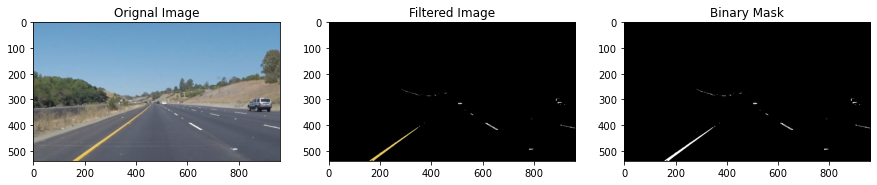

In [8]:
B[bool_x]=0
B[bool_y]=0

Binary_mask=B

filtered_image= np.zeros(image.shape, dtype=np.uint8)

filtered_image[bool_x]=image[bool_x] # Selecting white color region from RGB image
filtered_image[bool_y]=image[bool_y] # Selecting yellow color region from RGB image

f = plt.figure(figsize=(15,15))
ax = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)

ax.imshow(image)
ax.title.set_text('Orignal Image')
ax2.imshow(filtered_image)
ax2.title.set_text('Filtered Image')
ax3.imshow(Binary_mask,cmap='binary')
ax3.title.set_text('Binary Mask')

plt.show()
plt.imsave(address+'Binary_Mask.png',B,cmap='binary')
plt.imsave(address+'Filtered_image.png',filtered_image)

<h2 style="text-align: center;"><strong>5. Converstion to gray scale</strong></h2>

In [9]:
Ig=cv2.cvtColor(filtered_image,cv2.COLOR_RGB2GRAY)
plt.imsave(address+'Filtered_image_gray.png',Ig,cmap='gray')


<h2 style="text-align: center;"><strong>6. Compute Edges and Apply Region of Interest</strong></h2>


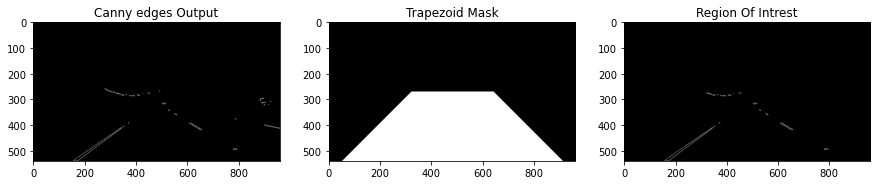

In [10]:
edges = cv2.Canny(Ig,80,160)
trapezoid=trapezoid_mask(edges.shape[0],edges.shape[1])
ROI=edges*trapezoid

f = plt.figure(figsize=(15,15))
ax = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
ax.imshow(edges,cmap='gray')
ax.title.set_text('Canny edges Output')
ax2.imshow(trapezoid,cmap='gray')
ax2.title.set_text('Trapezoid Mask')
                         
ax3.imshow(ROI,cmap='gray')
ax3.title.set_text('Region Of Intrest')

plt.show()
plt.imsave(address+'ROI.png',ROI,cmap='gray')

<h2 style="text-align: center;"><strong> 7. Run Hough Transformation algorithm and filter unwanted lines</strong></h2>

In [11]:
rho_res= 1             # 1 unit resolution
theta_res=np.pi/180    # 1 degree resolution
noi= 20               # No. of Intersections : Minimum number of intersections in rho-theta space to consider a line
minLineLen=int(edges.shape[0]/3)
maxLineGap=250
lines = cv2.HoughLinesP(ROI,  rho_res , theta_res , noi, minLineLen, maxLineGap=maxLineGap) 

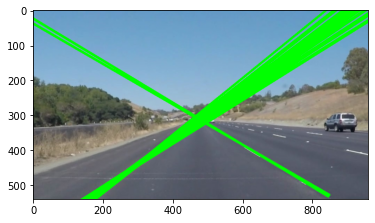

In [12]:
L=np.copy(image)
accumulator=hough_line(ROI)
edge_pixels = np.where(accumulator > 90)
coordinates = list(zip(edge_pixels[0], edge_pixels[1]))

    # Use line equation to draw detected line on an original image
for i in range(0, len(coordinates)):
    a = np.cos(np.deg2rad(coordinates[i][1]))
    b = np.sin(np.deg2rad(coordinates[i][1]))
    x0 = a*coordinates[i][0]
    y0 = b*coordinates[i][0]
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(L,(x1,y1),(x2,y2),(0,255,0),5)

    # show result
plt.imshow(L)
plt.show()

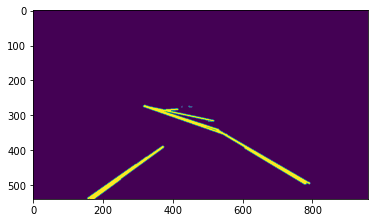

In [13]:
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(ROI, (x1, y1), (x2, y2), (255, 0, 0), 3)

   
plt.imshow(ROI)
plt.show()


Following plot is used to determine range of slopes for lines corresponding to lanes:



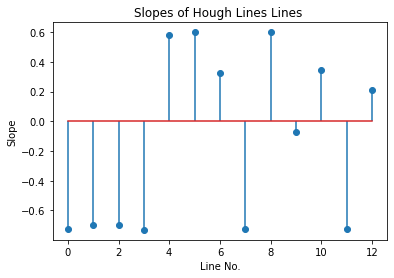

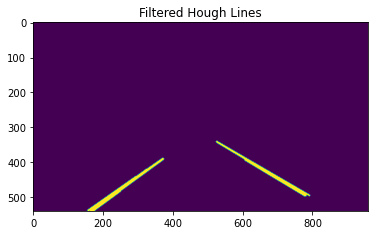

In [14]:
# Finding Slopes of Hough Lines

slopes=[]
for line in lines:   
    x1, y1, x2, y2 = line[0]
    slopes.append(round((y2-y1)/(x2-x1),3))


print('\nFollowing plot is used to determine range of slopes for lines corresponding to lanes:\n')    
plt.stem(slopes, use_line_collection=True)
plt.xlabel('Line No.')
plt.ylabel('Slope')
plt.title('Slopes of Hough Lines Lines ')
plt.show()


right_lane_lines_ind = []
left_lane_lines_ind  = []
mid_lane=[]



for count, slope in enumerate(slopes):
    if (slope > 0.4) & (slope < 2):
        right_lane_lines_ind.append(count)
    if (slope < -0.4) & (slope > -2):    
        left_lane_lines_ind.append(count)
    

right_lane_lines = lines[right_lane_lines_ind] 
left_lane_lines  = lines[left_lane_lines_ind]


#Plotting FilteredHoughLines
filt_line_img=np.zeros(ROI.shape, dtype=np.uint8)

for line in right_lane_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(filt_line_img, (x1, y1), (x2, y2), (255, 0, 0), 3)



for line in left_lane_lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(filt_line_img, (x1, y1), (x2, y2), (255, 0, 0), 3)
    

    
plt.imshow(filt_line_img)
plt.title('Filtered Hough Lines')

plt.show()    

<h2 style="text-align: center;"><strong> Linear Regression</strong></h2>

In [15]:
# Linear Regression on Right Lane Lines

right=0 # flag for existence of right lane lines

# Concatenating 0th and 2nd column of 'lines' matrix
x=np.concatenate( (np.array(right_lane_lines[:,:,0]) ,  np.array(right_lane_lines[:,:,2])), axis=0)


# Proceed if there are lines in right lane
if x.shape[0] is not 0:
    
    right=1 # flag for existence of right lane lines
    
    # Concatenating 1st and 3rd column of 'lines' matrix
    y=np.concatenate( (np.array(right_lane_lines[:,:,1]) ,  np.array(right_lane_lines[:,:,3])), axis=0)


    A= np.concatenate(( x, np.ones(x.shape,dtype=x.dtype) ), axis=1  )

    u= np.matmul( np.linalg.inv(np.matmul(A.T,A)) , A.T ).dot(y) 
    print('Result of Regression for Right Lanes')
    print('Slope(m): %f , y-Intercept(c): %f'%(u[0],u[1]))



    # Now get two points using m and c
    y1= int(ROI.shape[0]/1.5)         # Selecting y slightly below the mid of image height
    x1= int((y1- u[1])/u[0])          # Finding corresponding x-coordinate: x = ( y- c) / m
    print('\nFirst point is  (%d , %d)'%(x1,y1))

    y2= int(ROI.shape[0]-1)           # Selecting y at the bottom of image height
    x2= int((y2- u[1])/u[0])          # Finding corresponding x-coordinate: x = ( y- c) / m
    print('Second point is (%d , %d)'%(x2,y2))

Result of Regression for Right Lanes
Slope(m): 0.592393 , y-Intercept(c): 30.886452

First point is  (555 , 360)
Second point is (857 , 539)


<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-15-0822c8a5d0a6>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if x.shape[0] is not 0:


In [16]:
# Linear Regression on Left Lane Lines


left=0  # flag for existence of left lane lines

# Concatenating 0th and 2nd column of lines matrix
x=np.concatenate( (np.array(left_lane_lines[:,:,0]) ,  np.array(left_lane_lines[:,:,2])), axis=0)
 
# Proceed if there are lines in left lane    
if x.shape[0] is not 0: 
    
    left=1 # flag for existence of right lane lines
    
    # Concatenating 1st and 3rd column of lines matrix
    y=np.concatenate( (np.array(left_lane_lines[:,:,1]) ,  np.array(left_lane_lines[:,:,3])), axis=0)

    A= np.concatenate(( x, np.ones(x.shape,dtype=x.dtype) ), axis=1  )

    u= np.matmul( np.linalg.inv(np.matmul(A.T,A)) , A.T ).dot(y) 
    print('Result of Regression for Left Lanes:')
    print('Slope(m): %f , y-Intercept(c): %f'%(u[0],u[1]))



    # Now get two points using m and c
    y3= int(ROI.shape[0]/1.5)           #  Selecting y slightly below the mid of image height
    x3= int((y3- u[1])/u[0])            # Finding corresponding x-coordinate: x = ( y- c) / m
    print('\nFirst point is  (%d , %d)'%(x3,y3))

    y4= int(ROI.shape[0]-1)           # Selecting y in the bottom of image height
    x4= int((y4- u[1])/u[0])          # Finding corresponding x-coordinate: x = ( y- c) / m
    print('Second point is (%d , %d)'%(x4,y4))



Result of Regression for Left Lanes:
Slope(m): -0.721772 , y-Intercept(c): 657.976473

First point is  (412 , 360)
Second point is (164 , 539)


<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-16-e5eded334d5f>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if x.shape[0] is not 0:


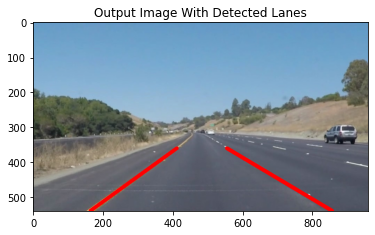

In [17]:
OutImage= np.copy(image)

if  right==1:
    cv2.line(OutImage, (x1, y1), (x2, y2), (255, 0, 0), 10)
if  left==1:    
    cv2.line(OutImage, (x3, y3), (x4, y4), (255, 0, 0), 10)

    
plt.imshow(OutImage)
plt.title('Output Image With Detected Lanes')
plt.show()

plt.imsave(address+'output.png',OutImage)